In [2]:
from windData import WindDataCollector
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import tensorflow as tf

tf.keras.utils.set_random_seed(1)

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import math
import pandas as pd

from influxdb import InfluxDBClient

import datetime

import timeit

In [3]:
def eval_metrics(actual, pred):
	rmse = np.sqrt(mean_squared_error(actual, pred))
	mae = mean_absolute_error(actual, pred)
	r2 = r2_score(actual, pred)
	return rmse, mae, r2


In [4]:
start_time = datetime.datetime(2021, 1, 1, 0, 0, 0).strftime("'%Y-%m-%dT%H:%M:%SZ'")

dataCollector = WindDataCollector()

gen_df = dataCollector.getGenerationData(now = start_time, delta="90")
wind_df = dataCollector.getWindData(now = start_time, delta="90")

gen_df_alligned = pd.merge_asof(wind_df,gen_df,left_index=True, right_index=True)

In [5]:
train_length = int(len(gen_df_alligned)*0.9)

train_X = gen_df_alligned.iloc[:train_length][[
   "Direction",
    "Speed",
    ]]
test_X = gen_df_alligned.iloc[train_length:][[
   "Direction",
    "Speed",
    ]]

train_y = gen_df_alligned.iloc[:train_length]["Total"]
test_y = gen_df_alligned.iloc[train_length:]["Total"]

## MLP

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

### Data prep and functions

In [6]:
normalizer = tf.keras.layers.Normalization(axis=-1)
windspeed = train_X["Speed"].to_numpy()
windspeed_normalizer = layers.Normalization(input_shape=[1,], axis=None)
windspeed_normalizer.adapt(windspeed)

2023-01-21 13:09:01.720689: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
def plot_loss(history, title):
  plt.figure(figsize=(5,2))
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='validation')
  plt.ylim([0, 12.5])
  plt.xlabel('Epoch')
  plt.ylabel('MAE [MW]')
  plt.title(title)
  plt.legend()
  plt.grid(True)
  # plt.savefig("./plots/" + title + ".pdf", bbox_inches='tight') # last part makes sure that the whole fig is saved.
  plt.show()

In [10]:
def plot_loss_compared(hist1, hist2):
  plt.plot(hist1.history['loss'], label='GD loss', color = "#0081C9", alpha = 0.8)
  plt.plot(hist2.history['loss'], label='SGD loss', color = "black", alpha = 0.8)
  #plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

# New experiments, with batch_size, steps_per_epoch etc.

## Gradient Descent

In [11]:
# For dedfining batch size and steps per epoch we need the size of the training set. 
val_split = 0.8
len_train_X = int( len(train_X) * val_split )

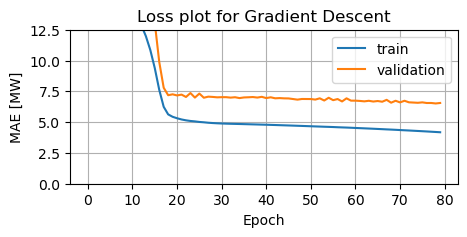

2/2 [==============================] - 0s 2ms/step
  RMSE: 4.792014678895554
  MAE: 3.994098287202865
  R2: 0.8625611740255095


In [12]:
tf.keras.utils.set_random_seed(1)

def build_and_compile_model_GD(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.experimental.SGD(0.1))
  return model

dnn_windspeed_model_GD = build_and_compile_model_GD(windspeed_normalizer)

power_GD = dnn_windspeed_model_GD.fit(
    train_X['Speed'],
    train_y,
    validation_split=0.2,
    verbose=0, 
    epochs=80,
    batch_size = len_train_X,
    steps_per_epoch = 1, # it is default value (batch_size / len(train)) = 1
    )

plot_loss(power_GD, "Loss plot for Gradient Descent")

predictions = dnn_windspeed_model_GD.predict(test_X["Speed"])

# Save predictions to plot later.
pred_gd = np.c_[test_X['Speed'].to_numpy(), predictions]
pred_gd = pred_gd[pred_gd[:, 0].argsort()]
pred_gd

# Metrics
(rmse, mae, r2) = eval_metrics(test_y, predictions)
print("  RMSE: %s" % rmse)
print("  MAE: %s" % mae)
print("  R2: %s" % r2)

## Stochastic Gradient Descent

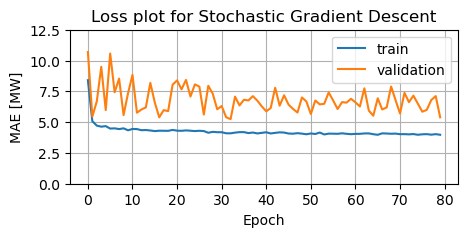

2/2 [==============================] - 0s 2ms/step
  RMSE: 3.9807588611957905
  MAE: 3.1211473009847004
  R2: 0.9051570839665514


In [13]:
# Started with Learning rate 0.1, but didnt converge. Changed Learning rate to 0.01 -- Better, very datapoint gets a bit less influence.

tf.keras.utils.set_random_seed(1)

def build_and_compile_model_SGD(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.experimental.SGD(0.01))
  return model

dnn_windspeed_model_SGD = build_and_compile_model_SGD(windspeed_normalizer)

power_SGD = dnn_windspeed_model_SGD.fit(
    train_X['Speed'],
    train_y,
    validation_split=0.2,
    verbose=0, 
    epochs=80,
    batch_size = 1,
    steps_per_epoch = len_train_X, # it is default value (batch_size / len(df)) = len(df)
    )

plot_loss(power_SGD, "Loss plot for Stochastic Gradient Descent")

predictions = dnn_windspeed_model_SGD.predict(test_X["Speed"])

# Save predictions to plot later.
pred_sgd = np.c_[test_X['Speed'].to_numpy(), predictions]
pred_sgd = pred_sgd[pred_sgd[:, 0].argsort()]
pred_sgd

# Metrics
(rmse, mae, r2) = eval_metrics(test_y, predictions)
print("  RMSE: %s" % rmse)
print("  MAE: %s" % mae)
print("  R2: %s" % r2)

## Mini-batch Gradient Descent

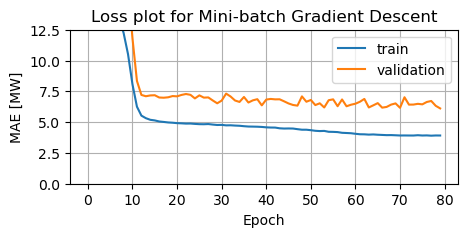

2/2 [==============================] - 0s 2ms/step
  RMSE: 4.3258614544932845
  MAE: 3.4976446955079576
  R2: 0.8879999105864458


In [14]:
tf.keras.utils.set_random_seed(1)

def build_and_compile_model_MGD(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.experimental.SGD(0.01))
  return model

dnn_windspeed_model_MGD = build_and_compile_model_MGD(windspeed_normalizer)

power_MGD = dnn_windspeed_model_MGD.fit(
    train_X['Speed'],
    train_y,
    validation_split=0.2,
    verbose=0, 
    epochs=80,
    batch_size = 32, # this is the default value
    # steps_per_epoch # when commented out and set to default value it calculated = (batch_size / len(df)).
    )

plot_loss(power_MGD, "Loss plot for Mini-batch Gradient Descent")

predictions = dnn_windspeed_model_MGD.predict(test_X["Speed"])

# Save predictions to plot later.
pred_mb = np.c_[test_X['Speed'].to_numpy(), predictions]
pred_mb = pred_mb[pred_mb[:, 0].argsort()]
pred_mb

# Metrics
(rmse, mae, r2) = eval_metrics(test_y, predictions)
print("  RMSE: %s" % rmse)
print("  MAE: %s" % mae)
print("  R2: %s" % r2)
%timeit

In [15]:
test_X['Speed']

time
2020-12-24 06:00:00+00:00    15.19936
2020-12-24 09:00:00+00:00    12.96416
2020-12-24 12:00:00+00:00     9.83488
2020-12-24 15:00:00+00:00     9.83488
2020-12-24 18:00:00+00:00     8.94080
                               ...   
2020-12-31 12:00:00+00:00    15.19936
2020-12-31 15:00:00+00:00    12.96416
2020-12-31 18:00:00+00:00    13.85824
2020-12-31 21:00:00+00:00    12.96416
2021-01-01 00:00:00+00:00    11.17600
Name: Speed, Length: 63, dtype: float64

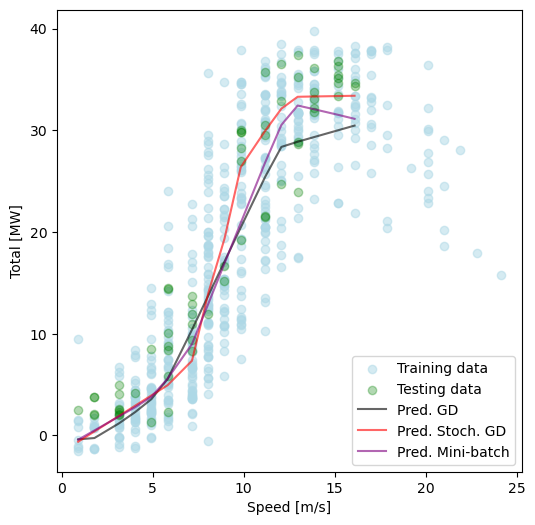

In [23]:
def plot_preds(traindata = train_X,
               trainlabels = train_y,
               testdata = test_X,
               testlabels = test_y,
               testdata_sort = test_X,
               pred1 = pred_gd,
               pred2 = pred_sgd,
               pred3 = pred_mb,
               ):
  plt.figure(figsize=(6,6))
  # plt.scatter(traindata, trainlabels, label="Training data", edgecolors="lightblue", facecolors = 'None', alpha =0.6)
  plt.scatter(traindata, trainlabels, label="Training data", color="lightblue", alpha =0.5)
  plt.scatter(testdata, testlabels, label="Testing data", c="green", alpha=0.3)
  plt.plot(pred_gd[:,0], pred_gd[:,1], c="black", label="Pred. GD", alpha=0.6)
  plt.plot(pred_sgd[:,0], pred_sgd[:,1], c="red", label="Pred. Stoch. GD", alpha = 0.6)
  plt.plot(pred_mb[:,0], pred_mb[:,1], c="purple", label="Pred. Mini-batch", alpha=0.6)
  plt.xlabel('Speed [m/s]')
  plt.ylabel('Total [MW]')
  plt.legend()
  plt.savefig("plots/predictions_gradient_descent.pdf")

plot_preds(
  train_X['Speed'],
  train_y,
  test_X['Speed'],
  test_y,
  test_X['Speed'],
  pred_gd,
  pred_sgd,
  pred_mb,
)

# Old experiments

In [ ]:
# def build_and_compile_model_GD(norm):
#   model = keras.Sequential([
#       norm,
#       layers.Dense(32, activation='relu'),
#       layers.Dense(16, activation='relu'),
#       layers.Dense(1)
#   ])

#   model.compile(loss='mean_absolute_error',
#                 optimizer=tf.compat.v1.train.GradientDescentOptimizer(0.1))
#   return model


# def build_and_compile_model_SGD(norm):
#   model = keras.Sequential([
#       norm,
#       layers.Dense(32, activation='relu'),
#       layers.Dense(16, activation='relu'),
#       layers.Dense(1)
#   ])

#   model.compile(loss='mean_absolute_error',
#                 optimizer=tf.keras.optimizers.experimental.SGD(0.1))
#   return model

## Gradient descent

In [ ]:
# dnn_windspeed_model_GD = build_and_compile_model_GD(windspeed_normalizer)

In [ ]:
# power_GD = dnn_windspeed_model_GD.fit(
#     train_X['Speed'],
#     train_y,
#     validation_split=0.2,
#     verbose=0, 
#     epochs=50,
#     batch_size = len(wind_df),
#     steps_per_epoch = 1,
#     )

In [ ]:
# plot_loss(power_GD)

In [ ]:
# predictions = dnn_windspeed_model_GD.predict(test_X["Speed"])
# (rmse, mae, r2) = eval_metrics(test_y, predictions)
# print("  RMSE: %s" % rmse)
# print("  MAE: %s" % mae)
# print("  R2: %s" % r2)

## Stochastic Gradient Descent

In [ ]:
# dnn_windspeed_model_SGD = build_and_compile_model_SGD(windspeed_normalizer)

In [ ]:
# power_SGD = dnn_windspeed_model_SGD.fit(
#     train_X['Speed'],
#     train_y,
#     validation_split=0.2,
#     verbose=0, 
#     epochs=3000,
#     batch_size = 1,
#     steps_per_epoch = 1,
#     )

In [ ]:
# plot_loss(power_SGD)

In [ ]:
# predictions = dnn_windspeed_model_SGD.predict(test_X["Speed"])
# (rmse, mae, r2) = eval_metrics(test_y, predictions)
# print("  RMSE: %s" % rmse)
# print("  MAE: %s" % mae)
# print("  R2: %s" % r2)

In [ ]:
# plot_loss_compared(power_GD, power_SGD)